In [23]:
# https://chatgpt.com/c/672baf61-2110-800e-96e2-0101a34c7796

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# INSTALLING REQUIRED LIBRARIES
!pip install plotly
!pip install osmnx
!pip install contextily
!pip install cartopy
!pip install -U pyproj -q
!pip install -U utm -q
!pip install -U google-colab -q
!pip install -U tornado -q
!pip install geemap -q
!pip install wxee
!pip install plotly --upgrade
!pip install -U kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 70.5 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
  Attempting uninstall: geopandas
    Found existing installation: geopandas 1.0.1
    Uninstalling geopandas-1.0.1:
      Successfully uninstalled geopandas-1.0.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 27.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.2 MB/s eta 0:00:00
   ━━━━

In [3]:
!pip install geemap

In [13]:
# !earthengine authenticate
import ee
import os
import wxee
# Set the path to the service account key file
service_account = 'editor@ee-manmeet20singh15-wbis.iam.gserviceaccount.com'
key_file = 'drive/MyDrive/earth_engine/ee-manmeet20singh15-wbis-fab7f1ca35e0.json'

# Use the service account for authentication
credentials = ee.ServiceAccountCredentials(service_account, key_file)
ee.Initialize(credentials)

In [5]:
# Define your study region (e.g., a polygon around Kerala)
region = ee.Geometry.Rectangle([76.2, 8.0, 77.4, 12.0])  # Modify with the region of interest

In [6]:
# Step 1: Load and Process Rainfall Data
# Load daily rainfall data (e.g., CHIRPS data)
rainfall_collection = ee.ImageCollection("UCSB-CHG/CHIRPS/DAILY") \
    .filterBounds(region) \
    .filterDate('2023-01-01', '2023-12-31')  # Define date range

In [21]:
# Define rainfall threshold (e.g., mm/day) to indicate potential flooding
rainfall_threshold = 250  # mm

In [22]:
# Select a daily rainfall image (for one day or loop over dates for time series)
rainfall_image = rainfall_collection.mean().clip(region)

In [9]:
# Step 2: Calculate Runoff (simplified model)
# Runoff = Rainfall - infiltration, simplified to use a runoff coefficient
# Assuming a runoff coefficient of 0.6 (high for urban areas or low permeability soils)
runoff_coefficient = 0.6
runoff_image = rainfall_image.multiply(runoff_coefficient).rename("runoff")

In [10]:
# Step 3: Load DEM and Calculate Flow Accumulation and Direction
# Load DEM data
dem = ee.Image("USGS/SRTMGL1_003").clip(region)

# Calculate slope to serve as a proxy for flow direction
slope = ee.Terrain.slope(dem)

# Calculate flow accumulation using DEM to route water flow
flow_accumulation = ee.Image("WWF/HydroSHEDS/15ACC").clip(region)  # HydroSHEDS as a proxy

In [11]:
# Step 4: Estimate Water Depth using Flow Accumulation and Runoff
# Combine runoff and flow accumulation to estimate potential inundation depth
# Depth = Flow accumulation (m³) * runoff (m) / cell area (m²)
cell_size = 30 * 30  # cell area in m² for 30m resolution

# Convert flow accumulation to volume of water (m³)
water_volume = flow_accumulation.multiply(runoff_image).multiply(cell_size)

# Estimate depth by dividing water volume by cell area
depth_image = water_volume.divide(cell_size).rename("water_depth")

In [16]:
depth_image = depth_image.set('system:time_start', 0)
ds_depth = depth_image.wx.to_xarray(region=region.bounds(), scale=200)

Downloading:   0%|          | 0.00/602k [00:00<?, ?iB/s]

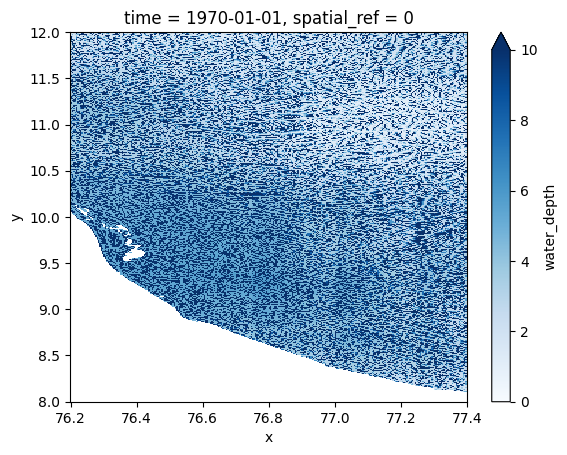

In [20]:
ds_depth.water_depth.plot(vmin=0, vmax=10, cmap='Blues')

In [ ]:
# Step 5: Define Flood Inundation Based on Water Depth and DEM
# Set a threshold for inundation based on depth (e.g., areas with >0.3m water depth are inundated)
flood_threshold = 0.3  # meters

# Calculate inundation areas where water depth exceeds the threshold
flood_inundation = depth_image.gt(flood_threshold).rename("flood_inundation")

# Step 6: Visualize and Export Results
# Display each step in the map for inspection (if running in GEE's Code Editor, not in Python)
Map = geemap.Map()
Map.centerObject(region)
Map.addLayer(rainfall_image, {'min': 0, 'max': 100, 'palette': ['blue', 'green', 'yellow', 'red']}, 'Rainfall')
Map.addLayer(dem, {'min': 0, 'max': 3000, 'palette': ['white', 'brown', 'green', 'blue']}, 'DEM')
Map.addLayer(flow_accumulation, {'min': 0, 'max': 5000, 'palette': ['00FFFF', '0000FF']}, 'Flow Accumulation')
Map.addLayer(depth_image, {'min': 0, 'max': 5, 'palette': ['white', 'blue']}, 'Water Depth')
Map.addLayer(flood_inundation, {'palette': 'red'}, 'Flood Inundation')
Map.add_colorbar(colorbar_dict={'width': '300px'}, label="Depth (m)")
Map

# Export the flood inundation layer to Google Drive
Export.image.toDrive({
    'image': flood_inundation,
    'description': 'Flood_Inundation_Map',
    'scale': 30,
    'region': region
})
